In [2]:
# Download the model
import argparse
import numpy as np
import PIL.Image
import dnnlib
import re
import sys
from io import BytesIO
import IPython.display
import numpy as np
from math import ceil
from PIL import Image, ImageDraw
import imageio
import matplotlib.pyplot as plt
import legacy
import cv2
import torch
from tqdm.autonotebook import tqdm

device = torch.device('cuda')

# Choose between these pretrained models
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/afhqcat.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/afhqdog.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/afhqwild.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/brecahad.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/cifar10.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl
# https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/metfaces.pkl

network_pkl = "https://nvlabs-fi-cdn.nvidia.com/stylegan2-ada-pytorch/pretrained/ffhq.pkl"

# If downloads fails, you can try downloading manually and uploading to the session directly 
# network_pkl = "/content/ffhq.pkl"

print('Loading networks from "%s"...' % network_pkl)
with dnnlib.util.open_url(network_pkl) as f:
  G = legacy.load_network_pkl(f)['G_ema'].to(device) # type: ignore

Loading networks from "./results/chexpert_network-snapshot-001620.pkl"...


In [3]:
# Useful utility functions...

# Generates an image from a style vector.
def generate_image_from_style(dlatent, noise_mode='none'):

  if len(dlatent.shape) == 1: 
    dlatent = dlatent.unsqueeze(0)
    
  row_images = G.synthesis(dlatent, noise_mode=noise_mode)
  row_images = (row_images.permute(0, 2, 3, 1) * 127.5 + 128).clamp(0, 255).to(torch.uint8)
  return row_images[0].cpu().numpy()    

# Converts a noise vector z to a style vector w.
def convert_z_to_w(latent, truncation_psi=0.7, truncation_cutoff=9, class_idx=None):
  label = torch.zeros([1, G.c_dim], device=device)   
  if G.c_dim != 0:
    if class_idx is None:
      RuntimeError('Must specify class label with class_idx when using a conditional network')
    label[:, class_idx] = 1
  else:
    if class_idx is not None:
      print(f'warning: class_idx={class_idx} ignored when running on an unconditional network')
  return G.mapping(latent, label, truncation_psi=truncation_psi, truncation_cutoff=truncation_cutoff)
     

In [1]:
# download 
!gdown "1NcRdVWicD1pS1X_XN3MfBrXQwffhB3wF" -O "../"

/home/uwaejaso/.conda/envs/ada/lib/python3.8/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [ ]:
python generate.py --gpu 1 --dir ./runs/brats2020-onlineslim-predstep-1-uniform-shakedrop0.75-beta20/test_16 --N 16 --res 28 --input_nc 1 --num_samples 100000 --ckpt ./runs/brats2020-onlineslim-predstep-1-uniform-shakedrop0.75-beta20/flow_model_100000_ema.pth --config_en configs/mnist_en.json --config_de configs/mnist_de.json --dataset mnist --solver euler --shakedrop --phi 0.75 --save_sub_traj --save_z # Runge-Kutta 12

In [ ]:
python train_distill_update.py  --N 16 --gpu 0,1,2,3  --dir ./runs/mnist-onlineslim-predstep-1-uniform-shakedrop0.75-beta20/ --latent_dir ./runs/mnist-onlineslim-predstep-1-uniform-shakedrop0.75-beta20/zs/ --traj_dir ./runs/mnist-onlineslim-predstep-1-uniform-shakedrop0.75-beta20/test_16/ --learning_rate 3e-4 --optimizer adam --batchsize 256 --iterations 40000 --flow_ckpt ./runs/mnist-onlineslim-predstep-1-uniform-shakedrop0.75-beta20/flow_model_500000_ema.pth --config_en configs/ mnist_en.json --config_de configs/mnist_de.json --pred_step 1

In [ ]:
python train_distill_update.py  --N 16 --gpu 0,1,2,3  --dir ./runs/brats2020-onlineslim-predstep-1-uniform-shakedrop0.75-beta20/ --latent_dir ./runs/brats2020-onlineslim-predstep-1-uniform-shakedrop0.75-beta20/test_16/zs/ --traj_dir ./runs/brats2020-onlineslim-predstep-1-uniform-shakedrop0.75-beta20/test_16/ --learning_rate 3e-4 --optimizer adam --batchsize 256 --iterations 40000 --flow_ckpt ./runs/brats2020-onlineslim-predstep-1-uniform-shakedrop0.75-beta20/flow_model_100000_ema.pth --config_en configs/ mnist_en.json --config_de configs/mnist_de.json --pred_step 1

In [2]:
# # Update csv files
# import pandas as pd
# import os

# # Define paths to CSV files
# train_csv = "../chexpert/versions/1/train.csv"
# test_csv = "../chexpert/versions/1/valid.csv"

# # Function to update paths in the CSV
# def update_paths(csv_file, current_prefix, new_prefix):
#     """
#     Updates file paths in the CSV file.
    
#     Args:
#         csv_file (str): Path to the CSV file.
#         current_prefix (str): Current incorrect prefix in file paths.
#         new_prefix (str): New correct prefix for file paths.
#     """
#     # Load CSV
#     df = pd.read_csv(csv_file)
 
#     # Assuming the first column contains the file paths
#     df.iloc[:, 0] = df.iloc[:, 0].str.replace(current_prefix, new_prefix)
    
#     # Assuming the first column contains the file paths
#     df.iloc[:, 0] = df.iloc[:, 0]
#     print(df.iloc[:, 0])
    
#     # Save the updated CSV back to disk
#     df.to_csv(csv_file, index=False)

# # Specify the incorrect and correct prefixes
# current_prefix = "CheXpert-v1.0-small/train/"
# new_prefix = "../chexpert/versions/1/train/"

# # Update train and test CSV files
# update_paths(train_csv, current_prefix, new_prefix)
# # update_paths(test_csv, current_prefix, new_prefix)

# print("Paths updated successfully in train.csv and test.csv!")


In [3]:
import os
import pandas as pd
from torch.utils.data import Dataset, DataLoader
from torchvision import transforms, models
import torch
from PIL import Image
from tqdm import tqdm

# Custom Dataset for CheXpert
class CheXpertDataset(Dataset):
    def __init__(self, csv_file, root_dir, transform=None):
        """
        Args:
            csv_file (string): Path to the csv file with annotations.
            root_dir (string): Directory with all the images.
            transform (callable, optional): Optional transform to be applied
                on a sample.
        """
        self.labels_df = pd.read_csv(csv_file)
        self.root_dir = root_dir
        self.transform = transform

    def __len__(self):
        return len(self.labels_df)

    def __getitem__(self, idx):
        if torch.is_tensor(idx):
            idx = idx.tolist()

        img_name = self.labels_df.iloc[idx, 0] # First column contains image paths
        image = Image.open(img_name).convert("RGB")  # Convert to RGB if grayscale
        label = 0 if self.labels_df.iloc[idx, 1] == "Female" else 1  # "sex" is the second column

        if self.transform:
            image = self.transform(image)

        return image, label

# Define paths
train_csv = "../chexpert/versions/1/train.csv"
train_dir = "../chexpert/versions/1/train/"
test_csv = "../chexpert/versions/1/valid.csv"
test_dir = "../chexpert/versions/1/valid/"

# Image transformations (augmentation and normalization)
transform = transforms.Compose([
    transforms.Resize((224, 224)),  # ResNet50 expects 224x224 images
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),  # Pretrained ResNet normalization
])

# Create datasets
train_dataset = CheXpertDataset(csv_file=train_csv, root_dir=train_dir, transform=transform)
test_dataset = CheXpertDataset(csv_file=test_csv, root_dir=test_dir, transform=transform)
print("Chexpert Dataset Loaded...")
train_dataset

Chexpert Dataset Loaded...


In [ ]:
import torchvision

batch_size = 16
train_loader = torch.utils.data.DataLoader(train_dataset, batch_size=batch_size, shuffle=True, num_workers=2)

# Load the ResNet50 model
model = torchvision.models.resnet50(pretrained=True)

# Parallelize training across multiple GPUs
model = torch.nn.DataParallel(model)

# Set the model to run on the device
model = model.to(device)

# Define the loss function and optimizer
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate)

# Train the model
for epoch in tqdm(range(num_epochs)):
    model.train()  # Set the model to training mode
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    for inputs, labels in train_loader:
        # Move input and label tensors to the device
        inputs = inputs.to(device)
        labels = labels.to(device)

        # Zero out the optimizer
        optimizer.zero_grad()

        # Forward pass
        outputs = model(inputs)
        loss = criterion(outputs, labels)

        # Backward pass
        loss.backward()
        optimizer.step()

        # Accumulate loss
        running_loss += loss.item()

        # Calculate accuracy
        _, predicted = torch.max(outputs, 1)  # Get predictions
        correct_predictions += (predicted == labels).sum().item()  # Compare predictions to labels
        total_samples += labels.size(0)
        
    # Calculate average loss and accuracy for the epoch
    epoch_loss = running_loss / len(train_loader)
    epoch_accuracy = correct_predictions / total_samples

    # Print loss and accuracy for the epoch
    print(f'Epoch {epoch+1}/{num_epochs}, Loss: {epoch_loss:.4f}, Accuracy: {epoch_accuracy:.4f}')

print('Finished Training!')


/home/uwaejaso/.conda/envs/ada/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/uwaejaso/.conda/envs/ada/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
  0%|          | 0/10 [00:00<?, ?it/s]

In [ ]:
# Save the model weights
save_path = "chexpert_resnet50_classifier.pth"
torch.save(model.state_dict(), save_path)
print(f"Model weights saved to {save_path}")

In [5]:
from torchvision import models as tv
import torch

classifier_path = "chexpert_resnet50_classifier.pth"

# Reload the model structure
cnn = torchvision.models.resnet50(pretrained=False)  # Set pretrained=False since we are loading custom weights
cnn = torch.nn.DataParallel(cnn)
# # Modify the fully connected layer for gender classification (if necessary)
# num_features = cnn.fc.in_features
# cnn.fc = torch.nn.Linear(num_features, 2)

# Load the saved weights
cnn.load_state_dict(torch.load(classifier_path))

# Move the model to the appropriate device
cnn = cnn.to(device)
cnn.eval()  # Set the model to evaluation mode
print("Model weights loaded successfully!")

/home/uwaejaso/.conda/envs/ada/lib/python3.8/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and will be removed in 0.15, please use 'weights' instead.
  warnings.warn(
/home/uwaejaso/.conda/envs/ada/lib/python3.8/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and will be removed in 0.15. The current behavior is equivalent to passing `weights=None`.
  warnings.warn(msg)


Model weights loaded successfully!


In [12]:
# Returns whether face is perceptually female (True) or male (False) given
# an input image of shape (H, W, 3).
def xray_is_female(img):
    im = np.asarray(img)/255.0
    im = cv2.resize(im, (256, 256))
#     im = Image.fromarray(im).convert("RGB") # if greyscale
    im = np.expand_dims(np.transpose(im, (2,0,1)), 0)
    im = torch.FloatTensor(im)
    logits = cnn(im)[0, 0]
    return (logits < 0.5).detach().cpu().numpy()

In [13]:
from tqdm import tqdm
import numpy as np
"""
:- Sample 1000 random z vectors
:- Then convert them to style vectors w
:- Get their corresponding perceived genders
"""
styles, genders = [],[]
for idx in tqdm(range(0,1000)):
    z = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device) # get random z vector
    w = convert_z_to_w(z, truncation_psi=0.7, truncation_cutoff=9) # convert to style vector
    img = generate_image_from_style(w) # generate image from w
    gen = xray_is_female(img)  # classify image with cnn classifier
    # save data
    styles.append(w.cpu().detach().numpy()); genders.append(gen)

100%|██████████| 1000/1000 [00:27<00:00, 36.07it/s]


In [14]:
# View some images
images = []
for idx in tqdm(range(0,1000)):
    z = torch.from_numpy(np.random.randn(1, G.z_dim)).to(device) # get random z vector
    w = convert_z_to_w(z, truncation_psi=0.7, truncation_cutoff=9) # convert to style vector
    images.append(generate_image_from_style(w)) # generate image from w

100%|██████████| 1000/1000 [00:11<00:00, 88.45it/s]


(256, 256)


(-0.5, 255.5, 255.5, -0.5)

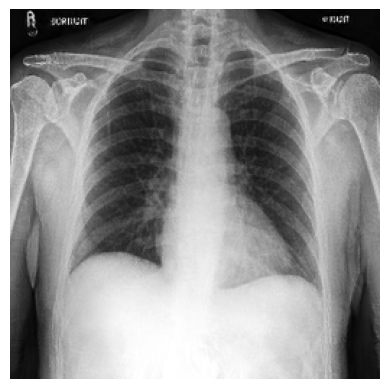

In [15]:
import matplotlib.pyplot as plt

print(images[0][:,:,0].shape)
plt.imshow(images[0][:,:,0], cmap="gray"); plt.axis(False)

In [16]:
from sklearn.svm import LinearSVC
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.datasets import make_classification

wX = []
for idx in range(len(styles)):
    wX.append(styles[idx].reshape((styles[0].shape[0]*styles[0].shape[1]*styles[0].shape[2])))

In [17]:
X, y = make_classification(n_features=4, random_state=0)
print(np.array(wX).shape, X.shape)
print(np.array(genders).shape, y.shape)

(1000, 8192) (100, 4)
(1000,) (100,)


In [18]:
clf = make_pipeline(LinearSVC(random_state=0, tol=1e-5))
clf.fit(wX, genders)

/home/uwaejaso/.conda/envs/ada/lib/python3.8/site-packages/sklearn/svm/_classes.py:32: FutureWarning: The default value of `dual` will change from `True` to `'auto'` in 1.5. Set the value of `dual` explicitly to suppress the warning.
  warnings.warn(
/home/uwaejaso/.conda/envs/ada/lib/python3.8/site-packages/sklearn/svm/_base.py:1250: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  warnings.warn(


Pipeline(steps=[('linearsvc', LinearSVC(random_state=0, tol=1e-05))])

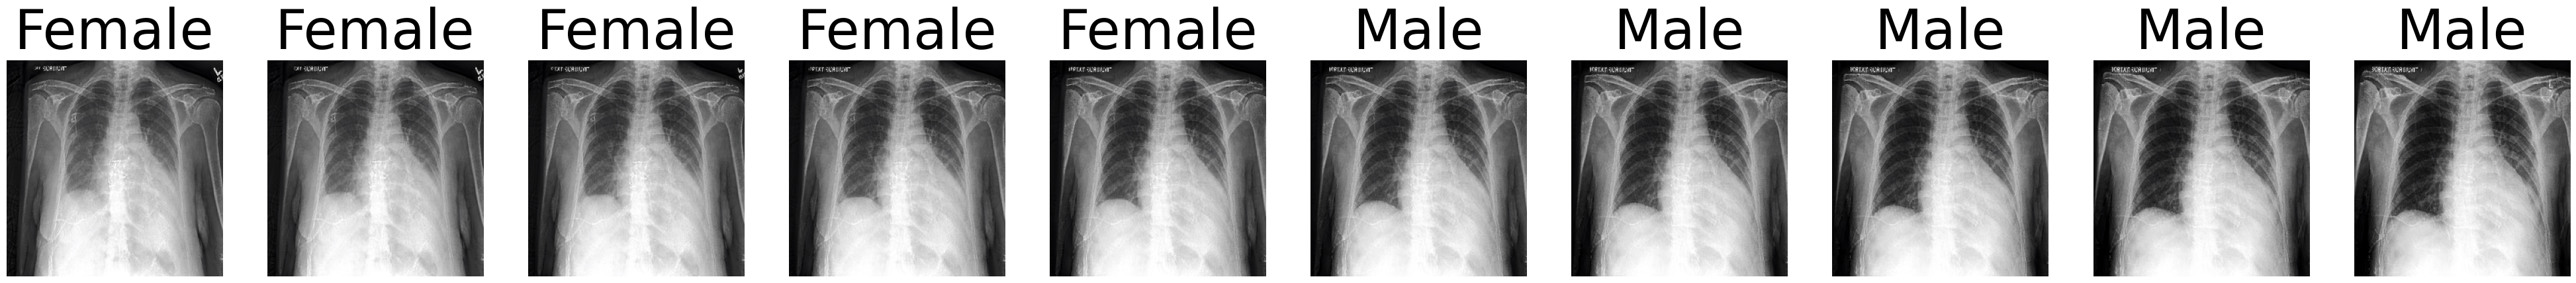

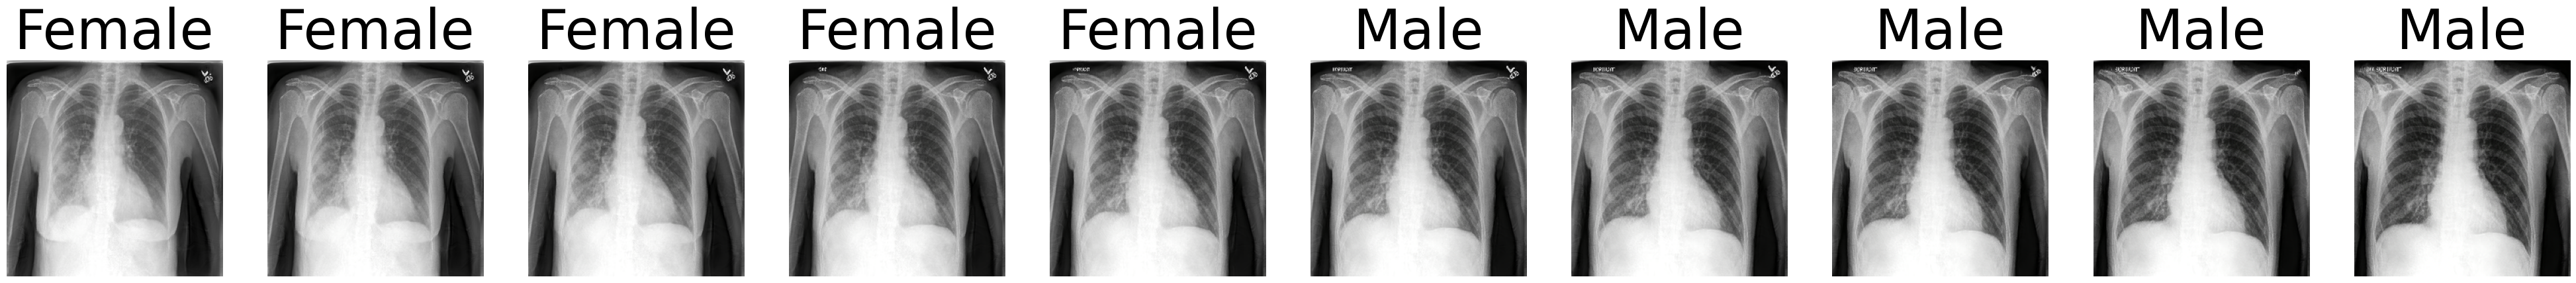

In [45]:
import random

fig, rows, columns = plt.figure(figsize=(50, 50)), 10,10

old_w = styles[7]; v = clf.named_steps['linearsvc'].coef_[0].reshape((styles[0].shape))
alpha = -30
for idx in range(10):
    new_w = old_w + alpha * v
    img = generate_image_from_style(torch.from_numpy(new_w).to('cuda'))
    fig.add_subplot(rows, columns, idx+1); plt.imshow(img,cmap='gray'); plt.axis('off')
    # Female classifier as title
    if(xray_is_female(img) == False):
        plt.title('Female', fontsize="60")
    else:
        plt.title('Male', fontsize="60")
    alpha += 5

old_w = styles[3];
fig, rows, columns = plt.figure(figsize=(50, 50)), 10,10
alpha = -30
for idx in range(10):
    new_w = old_w + alpha * v
    img = generate_image_from_style(torch.from_numpy(new_w).to('cuda'))
    fig.add_subplot(rows, columns, idx+1); plt.imshow(img,cmap='gray'); plt.axis('off')
    # Female classifier as title
    if(xray_is_female(img) == False):
        plt.title('Female', fontsize="60")
    else:
        plt.title('Male', fontsize="60")

    alpha += 5

In [32]:
import os
savepath = "results/cxr_interpolation/"
if not os.path.exists(savepath):
    os.makedirs(savepath)

In [33]:
old_w = styles[3]; v = clf.named_steps['linearsvc'].coef_[0].reshape((styles[0].shape))
alpha = -30
for idx in tqdm(range(50)):
    new_w = old_w + alpha * v
    img = generate_image_from_style(torch.from_numpy(new_w).to('cuda'))
    if(xray_is_female(img) == False):
        path = savepath+f"{idx}_f.png"
    else:
        path = savepath+f"{idx}_m.png"
    cv2.imwrite(path, img)
    alpha += 1

100%|██████████| 50/50 [00:01<00:00, 28.24it/s]


## Generate images from styles

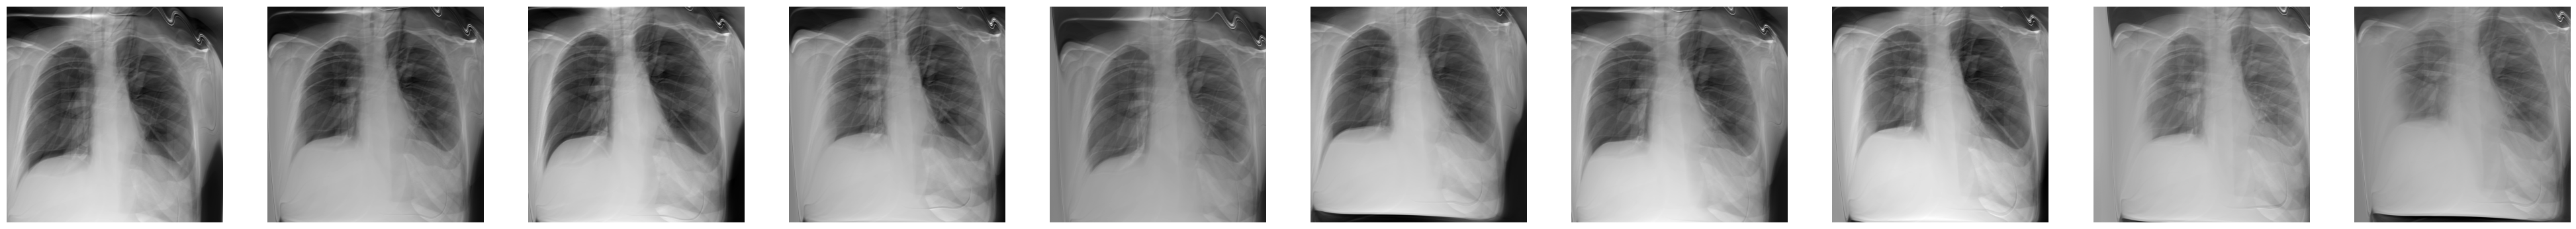

In [53]:
fig, rows, columns = plt.figure(figsize=(50, 50)), 10,10

for idx in range(20,30):
    img = generate_image_from_style(torch.from_numpy(styles[idx]).to('cuda'))
    fig.add_subplot(rows, columns, idx+1); plt.imshow(img,cmap='gray'); plt.axis('off')

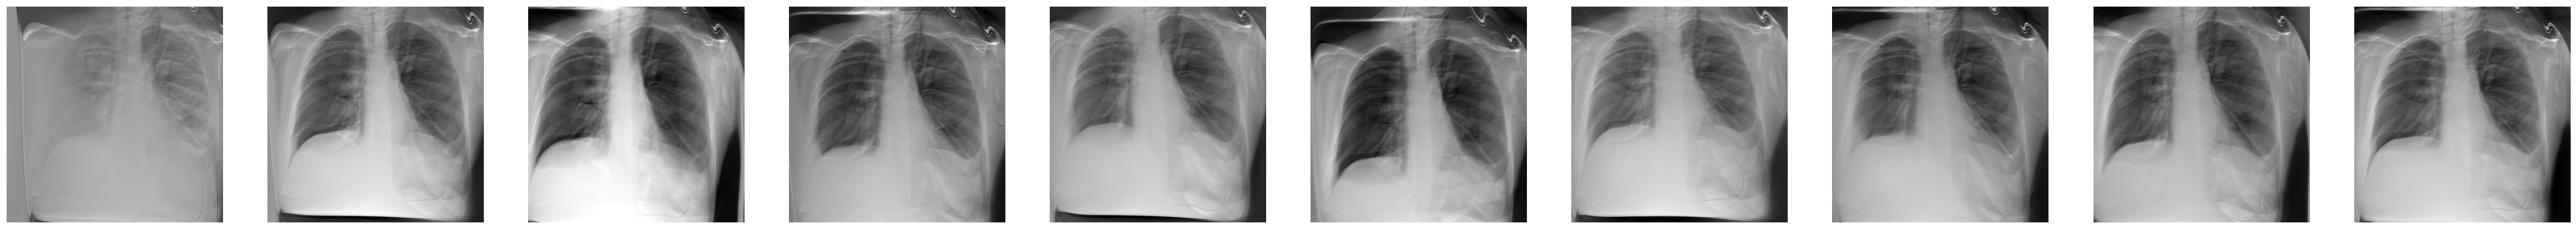

In [61]:
fig, rows, columns = plt.figure(figsize=(50, 50)), 10,10

for idx in range(90,100):
    img = generate_image_from_style(torch.from_numpy(styles[idx]).to('cuda'))
    fig.add_subplot(rows, columns, idx+1); plt.imshow(img,cmap='gray'); plt.axis('off')